обработка датасета

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_excel("accelerometer.xlsx")
df['AccX'] = df['AccX'].str.replace(',', '.').astype(float)
df['AccY'] = df['AccY'].str.replace(',', '.').astype(float)
df['AccZ'] = df['AccZ'].str.replace(',', '.').astype(float)
df['w'] = (df['AccX']**2+df['AccY']**2+df['AccZ']**2)**0.5


df

,t,AccX,AccY,AccZ,act,subj,w
0,0,9.074509,-1.946289,-0.368027,1,1,9.288175
1,1,8.911713,-2.267120,-0.116638,1,1,9.196307
2,2,8.972763,-2.453857,-0.219589,1,1,9.304843
3,3,8.930862,-2.386826,-0.296204,1,1,9.249052
4,4,8.769257,-2.394013,-0.306976,1,1,9.095350
...,...,...,...,...,...,...,...
695045,2217,8.405334,-0.411606,5.959854,5,15,10.312076
695046,2218,8.645950,-0.264374,5.008148,5,15,9.995193
695047,2219,9.268448,-0.373306,4.522125,5,15,10.319550
695048,2220,8.791992,-0.518158,3.176590,5,15,9.362603


In [ ]:
rr_w = pd.DataFrame()
rr_w_1 = pd.DataFrame()

for i in range(1,16):
  for j in range(1,6):
    df_w = df[(df['subj'] == i)&(df['act'] == j)]
    w_sm = pd.Series(df_w['w'].rolling(window=10).mean().iloc[9:].values)
    accx_sm = pd.Series(df_w['AccX'].rolling(window=10).mean().iloc[9:].values)
    accy_sm = pd.Series(df_w['AccY'].rolling(window=10).mean().iloc[9:].values)
    accz_sm = pd.Series(df_w['AccZ'].rolling(window=10).mean().iloc[9:].values)
    w_sm = pd.concat([w_sm, accx_sm, accy_sm, accz_sm], axis=1, keys=['w', 'accx_sm', 'accy_sm', 'accz_sm'])
    w_sm = w_sm.rename({0: 'w'}, axis=1)
    w_sm['act'] = j
    w_sm['subj'] = i
    rr_w = pd.concat([rr_w, w_sm], axis=0)

print(rr_w)

             w   accx_sm   accy_sm   accz_sm  act  subj
0     9.209152  8.893634 -2.307698 -0.508446    1     1
1     9.240934  8.925119 -2.295009 -0.561357    1     1
2     9.282293  8.967856 -2.245448 -0.690883    1     1
3     9.279527  8.962109 -2.166200 -0.864462    1     1
4     9.247012  8.927513 -2.071869 -1.031099    1     1
...        ...       ...       ...       ...  ...   ...
2208  9.510533  8.404735 -0.230611  4.374528    5    15
2209  9.562110  8.392525 -0.259940  4.515068    5    15
2210  9.632193  8.431431 -0.315366  4.597906    5    15
2211  9.605845  8.426044 -0.344455  4.536615    5    15
2212  9.575281  8.436220 -0.329491  4.426363    5    15

[694375 rows x 6 columns]


In [ ]:
result = pd.DataFrame()

for i in range(1,16):
  for j in range(1,6):
    #print(i)
    a = rr_w[(rr_w['subj'] == i)&(rr_w['act'] == j)]['w']
    l=len(a)
    #print(l)
    maxx_w = a.groupby(np.arange(l)//30).max()
    minn_w = a.groupby(np.arange(l)//30).min()
    rr = pd.concat([maxx_w.rename('maxx_w'), minn_w.rename('minn_w')], axis=1)
    rr['rng_w'] = rr['maxx_w'] - rr['minn_w']
    rr['step']  = np.where(rr['rng_w'] >= 2, 1, 0)
    rr['subj'] = i
    rr['act'] = j
    result = pd.concat([result, rr], axis=0)


print(result)

       maxx_w    minn_w     rng_w  step  subj  act
0    9.870968  8.706332  1.164636     0     1    1
1   10.607028  8.652945  1.954083     0     1    1
2   12.017763  8.601504  3.416259     1     1    1
3   11.074152  6.650465  4.423687     1     1    1
4   13.045106  8.324161  4.720946     1     1    1
..        ...       ...       ...   ...   ...  ...
69  12.677045  7.047135  5.629910     1    15    5
70  12.923265  7.200610  5.722654     1    15    5
71  11.435178  7.824138  3.611040     1    15    5
72   9.895400  8.607743  1.287657     0    15    5
73   9.949183  8.693710  1.255474     0    15    5

[23182 rows x 6 columns]


In [ ]:
n = 240



result_2 = pd.DataFrame()

for i in range(1,16):
  for j in range(1,6):

    step_rng = result[(result['subj']==i)&(result['act']==j)]['step']
 #   print(len(step_rng))
    n_steps= step_rng.groupby(np.arange(len(step_rng))//8).sum()

    subs = rr_w[(rr_w['subj'] == i)&(rr_w['act'] == j)]['w']

    l=len(subs)

    mean_w = subs.groupby(np.arange(l)//n).mean()
    max_w = subs.groupby(np.arange(l)//n).max()
    min_w = subs.groupby(np.arange(l)//n).min()
    std_w = subs.groupby(np.arange(l)//n).std()
    med_w = subs.groupby(np.arange(l)//n).median()
    correlxz = rr_w[(rr_w['subj'] == i)&(rr_w['act'] == j)].groupby(np.arange(l)//n)[['accx_sm','accz_sm']].corr().unstack().iloc[:,1]
    correlyz = rr_w[(rr_w['subj'] == i)&(rr_w['act'] == j)].groupby(np.arange(l)//n)[['accy_sm','accz_sm']].corr().unstack().iloc[:,1]
    correlxy = rr_w[(rr_w['subj'] == i)&(rr_w['act'] == j)].groupby(np.arange(l)//n)[['accx_sm','accy_sm']].corr().unstack().iloc[:,1]

    res = pd.concat([
    mean_w.rename('mean_w'), 
    max_w.rename('max_w'),
    min_w.rename('min_w'),
    std_w.rename('std_w'),
    med_w.rename('med_w'),
    correlxz.rename('correlxz'),
    correlyz.rename('correlyz'),
    correlyz.rename('correlxy'),
    n_steps.rename('n_steps')], 
    axis=1)

    res['subj'] = i
    res['act'] = j

    result_2 = pd.concat([result_2, res], axis=0)

print(result_2)



      mean_w      max_w     min_w     std_w     med_w  correlxz  correlyz  \
0   9.505161  13.045106  6.650465  1.024173  9.381103  0.201643  0.215083   
1   9.376744  11.894582  6.988495  0.514180  9.344144 -0.045267  0.386796   
2   9.306969   9.353547  9.254820  0.017896  9.305785 -0.807890 -0.461393   
3   9.311141   9.416896  9.226637  0.025105  9.309181 -0.679065 -0.248903   
4   9.312868   9.345451  9.280023  0.011448  9.312821 -0.888741 -0.632680   
..       ...        ...       ...       ...       ...       ...       ...   
5   9.277215  13.005038  6.987459  1.586280  8.932824 -0.143450 -0.004636   
6   9.689131  13.088391  6.833768  1.709278  9.494999 -0.285980  0.047768   
7   9.515585  12.511004  7.177699  1.424721  9.421365  0.060920 -0.239336   
8   9.486475  12.923265  6.995805  1.698867  9.185198 -0.175814  0.104386   
9   9.284944   9.949183  8.607743  0.369443  9.335294 -0.267973  0.716147   

    correlxy  n_steps  subj  act  
0   0.215083        3     1    1  
1   0

In [ ]:
result_2['t'] = result_2.index

result_2 = result_2.to_csv('train_df.csv', index = False)

result_2

In [ ]:
import pandas as pd
from sklearn import preprocessing

df = pd.read_csv('train_df.csv')

df.dropna(axis = 0, inplace = True)

X = df[['t','mean_w','max_w','min_w','std_w','med_w','n_steps','correlxz','correlyz']]

#X  = preprocessing.normalize(X)

Y = df['act']

Y

0       1
1       1
2       1
3       1
4       1
       ..
2928    5
2929    5
2930    5
2931    5
2932    5
Name: act, Length: 2932, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=109)
X_train = np.array(X_train)
X_test = np.array(X_test)


print(X_train.shape)
print(X_test.shape)

(2345, 9)
(587, 9)


SVM

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='sigmoid')

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3696763202725724


CatBoost

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.7 MB/s eta 0:00:00


In [ ]:
import catboost as ctb
from sklearn.model_selection import RandomizedSearchCV
from random import randint
from sklearn.model_selection import GridSearchCV

model_CBC = ctb.CatBoostClassifier()

grid = {'max_depth': [5,6,7],'n_estimators':[700, 800, 900], random_state=99}
gscv = GridSearchCV (estimator = model_CBC, param_grid = grid, scoring ='accuracy', cv = 5)



#Fit the model
gscv.fit(X_train,y_train)



print(gscv.best_estimator_)

#returns the best score
print(gscv.best_score_)

#returns the best parameters
print(gscv.best_params_)

Streaming output truncated to the last 5000 lines.
308:	learn: 0.0912179	total: 5.4s	remaining: 10.3s
309:	learn: 0.0908394	total: 5.43s	remaining: 10.3s
310:	learn: 0.0905431	total: 5.46s	remaining: 10.3s
311:	learn: 0.0903132	total: 5.49s	remaining: 10.3s
312:	learn: 0.0900825	total: 5.51s	remaining: 10.3s
313:	learn: 0.0898614	total: 5.54s	remaining: 10.3s
314:	learn: 0.0896349	total: 5.57s	remaining: 10.3s
315:	learn: 0.0893749	total: 5.59s	remaining: 10.3s
316:	learn: 0.0891507	total: 5.62s	remaining: 10.3s
317:	learn: 0.0887756	total: 5.65s	remaining: 10.3s
318:	learn: 0.0884742	total: 5.67s	remaining: 10.3s
319:	learn: 0.0882818	total: 5.71s	remaining: 10.3s
320:	learn: 0.0880515	total: 5.73s	remaining: 10.3s
321:	learn: 0.0879008	total: 5.76s	remaining: 10.3s
322:	learn: 0.0876486	total: 5.79s	remaining: 10.3s
323:	learn: 0.0873570	total: 5.8s	remaining: 10.3s
324:	learn: 0.0871882	total: 5.82s	remaining: 10.3s
325:	learn: 0.0869439	total: 5.83s	remaining: 10.3s
326:	learn: 0.0

In [ ]:
ctb.CatBoostClassifier?

In [ ]:
model_CBC = ctb.CatBoostClassifier(max_depth=7, n_estimators=800, random_seed=99)

model_CBC.fit(X_train,y_train)

predicted_y = model_CBC.predict(X_test)

Learning rate set to 0.099791
0:	learn: 1.3662995	total: 15.6ms	remaining: 12.4s
1:	learn: 1.2074589	total: 29.3ms	remaining: 11.7s
2:	learn: 1.0849222	total: 40.8ms	remaining: 10.8s
3:	learn: 0.9844172	total: 52.3ms	remaining: 10.4s
4:	learn: 0.9007103	total: 63.6ms	remaining: 10.1s
5:	learn: 0.8305554	total: 75ms	remaining: 9.93s
6:	learn: 0.7781797	total: 86.2ms	remaining: 9.76s
7:	learn: 0.7289588	total: 97.3ms	remaining: 9.63s
8:	learn: 0.6809174	total: 108ms	remaining: 9.52s
9:	learn: 0.6400273	total: 119ms	remaining: 9.43s
10:	learn: 0.6045520	total: 135ms	remaining: 9.71s
11:	learn: 0.5733477	total: 147ms	remaining: 9.66s
12:	learn: 0.5447752	total: 158ms	remaining: 9.57s
13:	learn: 0.5199103	total: 169ms	remaining: 9.5s
14:	learn: 0.4965885	total: 180ms	remaining: 9.44s
15:	learn: 0.4771092	total: 191ms	remaining: 9.38s
16:	learn: 0.4593036	total: 205ms	remaining: 9.46s
17:	learn: 0.4440660	total: 217ms	remaining: 9.42s
18:	learn: 0.4287988	total: 228ms	remaining: 9.37s
19:	le

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted_y))
print(metrics.confusion_matrix(y_test, predicted_y))

              precision    recall  f1-score   support

           1       0.92      0.90      0.91       193
           2       0.87      0.91      0.89       160
           3       0.96      0.96      0.96       167
           4       0.88      0.81      0.85        37
           5       0.74      0.77      0.75        30

    accuracy                           0.90       587
   macro avg       0.87      0.87      0.87       587
weighted avg       0.91      0.90      0.90       587

[[173  18   1   0   1]
 [ 14 145   0   1   0]
 [  0   2 160   1   4]
 [  0   2   2  30   3]
 [  1   0   4   2  23]]


Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_hp = DecisionTreeClassifier(random_state=42)

params = {'max_depth':[3,5,7,10,15],
          'min_samples_leaf':[3,5,10,15,20],
          'min_samples_split':[8,10,12,18,20,16],
          'criterion':['gini','entropy']}
GS = GridSearchCV(estimator=dt_hp,param_grid=params,cv=5,n_jobs=-1, verbose=True, scoring='accuracy')

GS.fit(X_train, y_train)

print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 12}

Best Score: 0.8818763326226013


In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=12, criterion='entropy',random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=12, random_state=42)

In [ ]:
y_estimate = tree_clf.predict(X_test)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_estimate))
print(metrics.confusion_matrix(y_test, y_estimate))

              precision    recall  f1-score   support

           1       0.90      0.81      0.85       193
           2       0.79      0.90      0.84       160
           3       0.95      0.96      0.96       167
           4       0.84      0.73      0.78        37
           5       0.69      0.67      0.68        30

    accuracy                           0.87       587
   macro avg       0.83      0.81      0.82       587
weighted avg       0.87      0.87      0.87       587

[[157  35   0   0   1]
 [ 16 144   0   0   0]
 [  0   2 160   1   4]
 [  0   2   4  27   4]
 [  2   0   4   4  20]]


KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)#Create new KNN object
clf = GridSearchCV(classifier, hyperparameters, cv=10)#Fit the model

best_model=clf.fit(X_train, y_train)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 24


In [ ]:
classifier = KNeighborsClassifier(leaf_size=1, p=1, n_neighbors=24)

classifier.fit(X_train, y_train)
y_estimate = classifier.predict(X_test)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_estimate))
print(metrics.confusion_matrix(y_test, y_estimate))

              precision    recall  f1-score   support

           1       0.82      0.72      0.77       193
           2       0.70      0.82      0.76       160
           3       0.96      0.93      0.95       167
           4       0.81      0.68      0.74        37
           5       0.59      0.73      0.66        30

    accuracy                           0.81       587
   macro avg       0.78      0.78      0.77       587
weighted avg       0.81      0.81      0.81       587

[[139  53   0   0   1]
 [ 29 131   0   0   0]
 [  1   1 156   2   7]
 [  1   1   3  25   7]
 [  0   1   3   4  22]]


Ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression



model_1 = LogisticRegression(random_state=16)
model_2 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=12, criterion='entropy',random_state=42)
model_4 = KNeighborsClassifier(leaf_size=1, p=1, n_neighbors=24)

# voting classifier
final_model = VotingClassifier(
    estimators=[("lr", model_1), ("rf", model_2), ("knn", model_4)],
    voting="soft",
)

# training
final_model.fit(X_train, y_train)

# prediction
prediction = final_model.predict(X_test)

# evaluation
accuracy = round(accuracy_score(y_test, prediction) * 100, 3)
##auc = round(roc_auc_score(y_test, prediction), 3)

print(f" Accuracy: {accuracy}%")
#print(f" AUC score: {auc}")

 Accuracy: 86.542%


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

              precision    recall  f1-score   support

           1       0.92      0.80      0.86       193
           2       0.78      0.92      0.84       160
           3       0.95      0.96      0.96       167
           4       0.82      0.76      0.79        37
           5       0.67      0.60      0.63        30

    accuracy                           0.87       587
   macro avg       0.83      0.81      0.81       587
weighted avg       0.87      0.87      0.86       587

[[154  37   1   0   1]
 [ 13 147   0   0   0]
 [  0   2 161   0   4]
 [  0   2   3  28   4]
 [  0   1   5   6  18]]


XGBoost

In [ ]:
import xgboost as xgb


y_train = y_train-1
xgb_cl = xgb.XGBClassifier()
# Init classifier
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test-1, preds)

0.9011925042589438

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test-1, preds))
print(metrics.confusion_matrix(y_test-1, preds))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       193
           1       0.84      0.92      0.88       160
           2       0.96      0.96      0.96       167
           3       0.91      0.78      0.84        37
           4       0.80      0.80      0.80        30

    accuracy                           0.90       587
   macro avg       0.89      0.87      0.88       587
weighted avg       0.90      0.90      0.90       587

[[168  24   1   0   0]
 [ 13 147   0   0   0]
 [  0   2 161   1   3]
 [  0   2   3  29   3]
 [  1   0   3   2  24]]


плотность распределения количества шагов по видам двигательной активности 

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/pytho

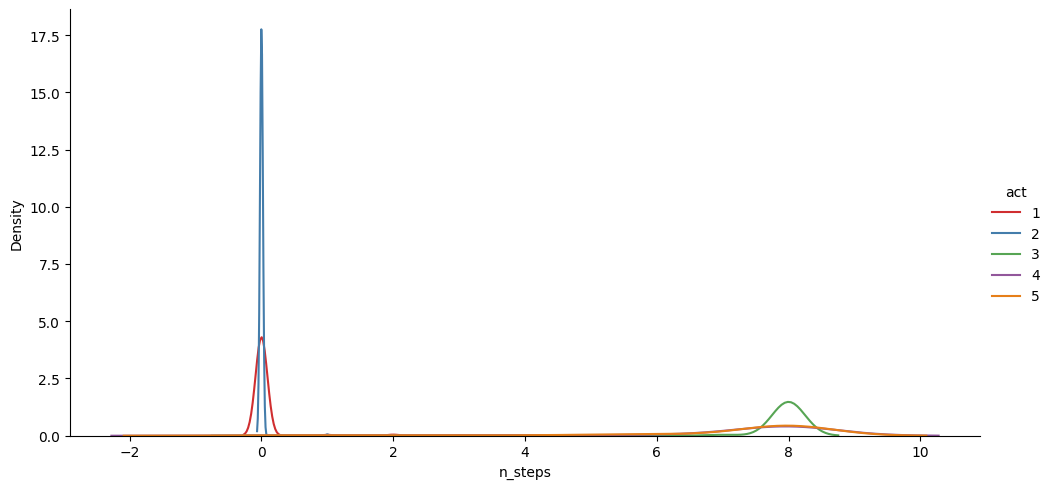

In [ ]:
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns




sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(df, hue='act', height=5,aspect=2)
facetgrid.map(sns.distplot,'n_steps', hist=False).add_legend()
plt.show()

плотность распределения максимального значения ускорения во фрейме по видам двигательной активности

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/pytho

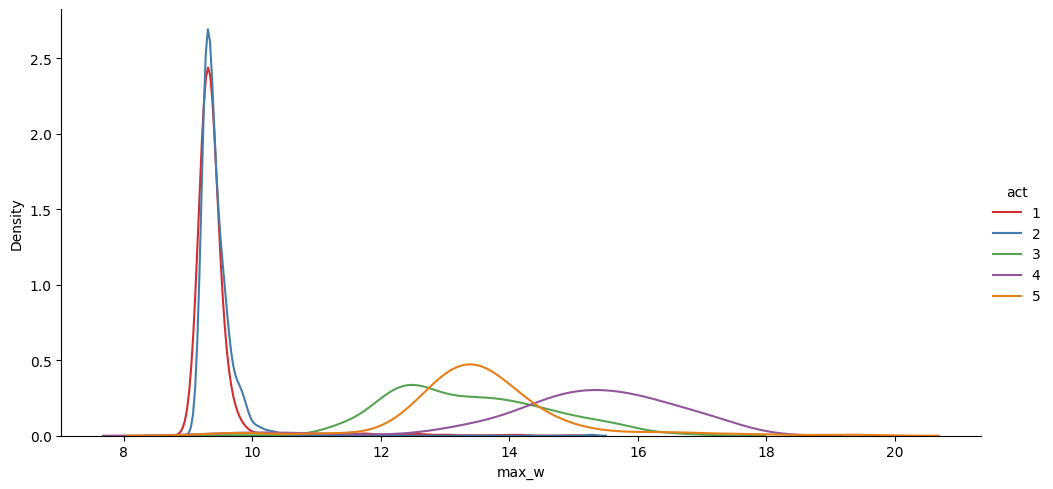

In [ ]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(df, hue='act', height=5,aspect=2)
facetgrid.map(sns.distplot,'max_w', hist=False).add_legend()
plt.show()

плотность распределения среднего квадратичного отклонения ускорения во фрейме по видам двигательной активности

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/pytho

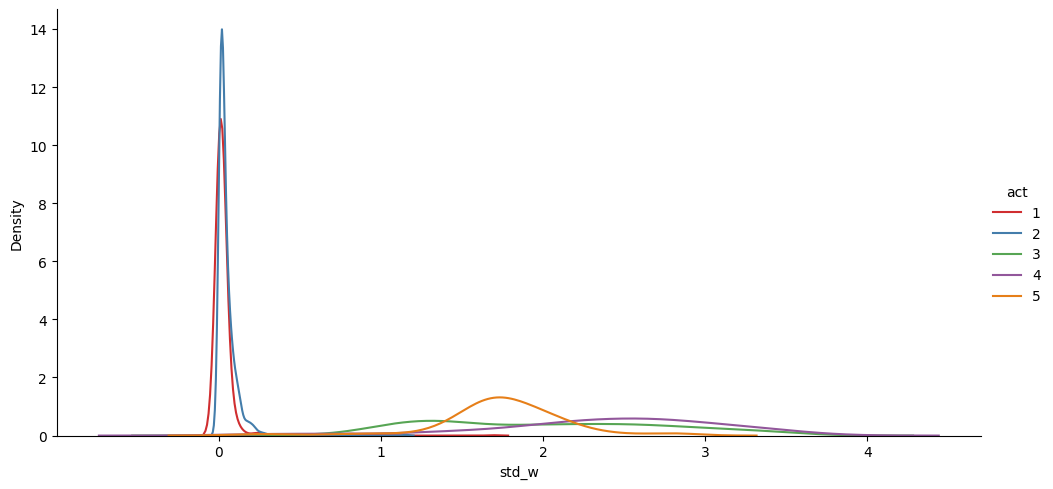

In [ ]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(df, hue='act', height=5,aspect=2)
facetgrid.map(sns.distplot,'std_w', hist=False).add_legend()
plt.show()

плотность распределения корреляции между усрением по оси z и x во фрейме по видам двигательной активности

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/pytho

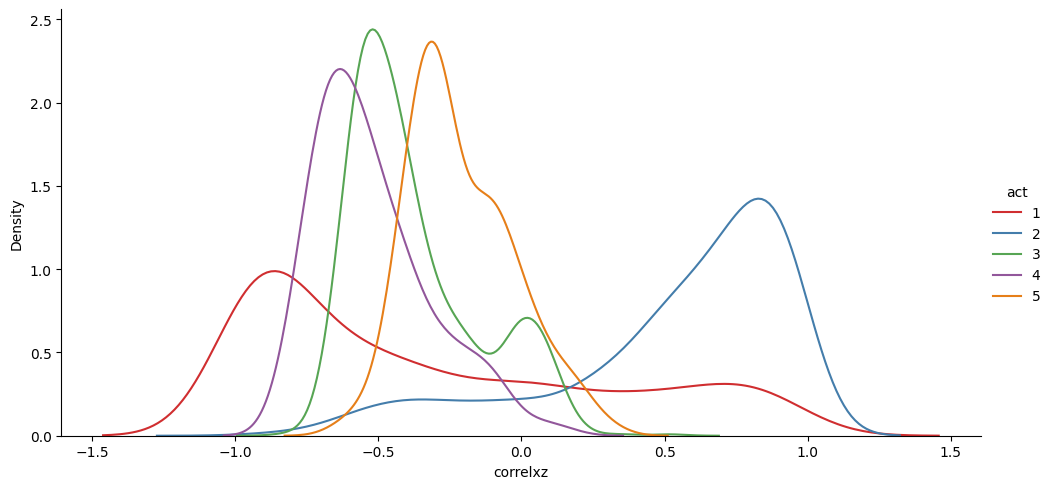

In [ ]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(df, hue='act', height=5,aspect=2)
facetgrid.map(sns.distplot,'correlxz', hist=False).add_legend()
plt.show()

плотность распределения среднего значения ускорения во фрейме по видам двигательной активности

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/pytho

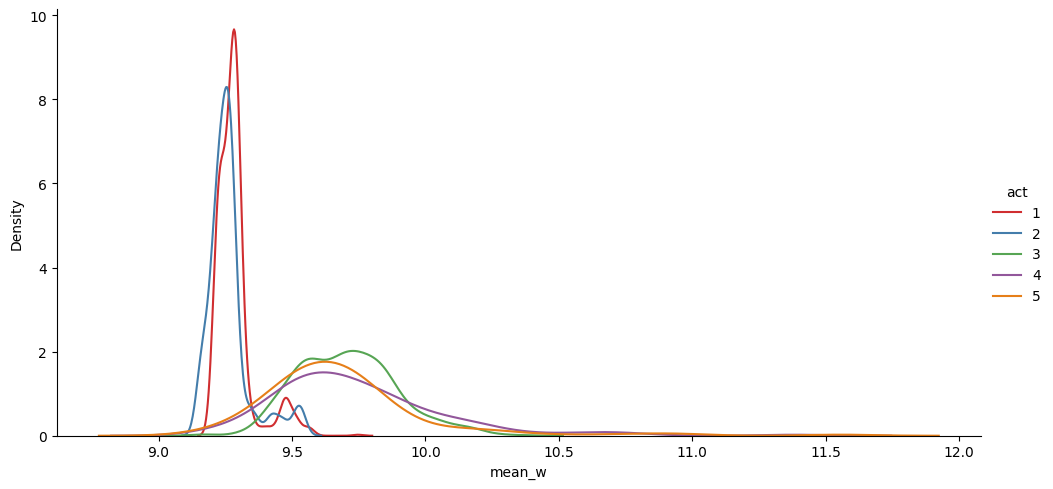

In [ ]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(df, hue='act', height=5,aspect=2)
facetgrid.map(sns.distplot,'mean_w', hist=False).add_legend()
plt.show()

LSTM

In [ ]:
X_train_n = np.array(X_test)
X_train_n = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
print(X_train_n.shape)
X_test_n = np.array(X_test)
X_test_n = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_test_n.shape)

(2345, 9, 1)
(587, 9, 1)


In [ ]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

y_train_n = y_train
y_test_n = y_test

onehot_encoder = OneHotEncoder(sparse=False)
y_train_n = y_train_n.values.reshape(-1, 1)
y_train_n = onehot_encoder.fit_transform(y_train_n)
y_test_n = y_test_n.values.reshape(-1, 1)
y_test_n = onehot_encoder.fit_transform(y_test_n)

print(y_test.shape)
print(y_train.shape)

(587,)
(2345,)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)


# Initializing parameters
epochs = 65
batch_size = 16
n_hidden = 64

In [ ]:
import pandas as pd
import numpy as np
import os
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2

n_classes = 5
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, return_sequences=True, input_shape=(9, 1)))

model.add(LSTM(n_hidden))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='sigmoid'))

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 9, 64)             16896     
                                                                 
 lstm_49 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_42 (Dense)            (None, 64)                4160      
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 5)                 325       
                                                                 
Total params: 54,405
Trainable params: 54,405
Non-tra

In [ ]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
# Training the model
train_history= model.fit(X_train_n, y_train_n, batch_size=batch_size, validation_data=(X_test_n, y_test_n),epochs=epochs)
train_history

Epoch 1/65
147/147 [==============================] - 5s 12ms/step - loss: 1.2093 - accuracy: 0.4431 - val_loss: 0.8026 - val_accuracy: 0.6014
Epoch 2/65
147/147 [==============================] - 1s 7ms/step - loss: 0.7830 - accuracy: 0.5791 - val_loss: 0.6894 - val_accuracy: 0.6048
Epoch 3/65
147/147 [==============================] - 1s 7ms/step - loss: 0.7101 - accuracy: 0.6081 - val_loss: 0.7412 - val_accuracy: 0.5963
Epoch 4/65
147/147 [==============================] - 1s 10ms/step - loss: 0.6828 - accuracy: 0.6183 - val_loss: 0.7143 - val_accuracy: 0.5894
Epoch 5/65
147/147 [==============================] - 2s 11ms/step - loss: 0.6594 - accuracy: 0.6542 - val_loss: 0.6535 - val_accuracy: 0.6354
Epoch 6/65
147/147 [==============================] - 1s 9ms/step - loss: 0.6293 - accuracy: 0.6917 - val_loss: 0.6781 - val_accuracy: 0.6269
Epoch 7/65
147/147 [==============================] - 1s 7ms/step - loss: 0.5842 - accuracy: 0.7305 - val_loss: 0.7073 - val_accuracy: 0.6201
Epo

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix


score = model.evaluate(X_test_n, y_test_n)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

19/19 [==============================] - 0s 4ms/step - loss: 0.4896 - accuracy: 0.7785

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.48958730697631836, 0.7785349488258362]


In [ ]:
y_pred=model.predict(X_test_n) 
y_pred=np.argmax(y_pred, axis=1)
y_test_n=np.argmax(y_test_n, axis=1)
cm = confusion_matrix(y_test_n, y_pred)

cm

19/19 [==============================] - 0s 3ms/step


array([[128,  62,   1,   2,   0],
       [ 16, 143,   1,   0,   0],
       [  1,   1, 146,  10,   9],
       [  2,   0,   3,  29,   3],
       [  1,   0,  17,   1,  11]])

In [ ]:
score = model.evaluate( X_test_n , y_test_n , batch_size = batch_size)
 
print( "Accuracy: {:0.4}".format( score[1] ))
 
print( "Loss:", score[0] )

ValueError: ignored

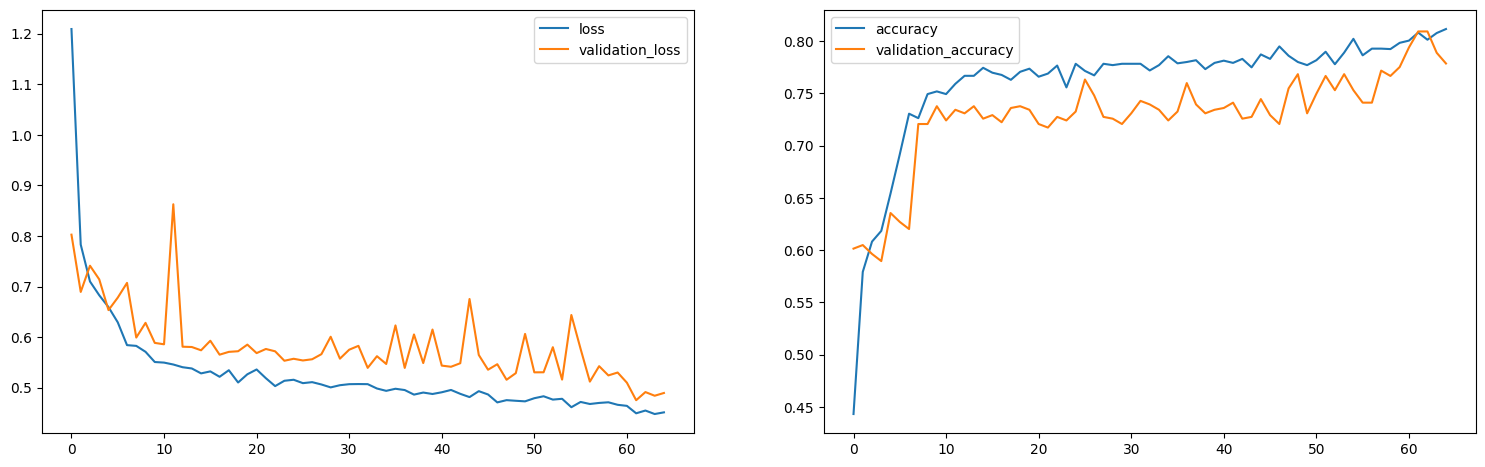

In [ ]:
import matplotlib.pyplot as plt

loss = train_history.history['loss']

validation_loss = train_history.history['val_loss']

accuracy = train_history.history['accuracy']

val_accuracy = train_history.history['val_accuracy']

fig = plt.gcf()

fig.set_size_inches(18.5, 5.5)

plt.subplot(1,2,1)

plt.plot(loss)

plt.plot(validation_loss)

plt.legend(['loss', 'validation_loss'])

plt.subplot(1,2,2)

plt.plot(accuracy)

plt.plot(val_accuracy)

plt.legend(['accuracy', 'validation_accuracy'])

plt.show()